# Visual Instruction Tuning - Inference

Test the instruction-tuned VLM with visual Q&A on COCO images.

In [1]:
import sys
sys.path.insert(0, '..')

import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from tokenizers import Tokenizer

from model import create_instruct_vlm, DEFAULT_CONFIG, DEFAULT_LLM_CKPT, DEFAULT_VLM_CKPT

# Paths
CHECKPOINT_PATH = Path('../checkpoints/best_instruct.pt')
COCO_DIR = Path('/home/smedar/fiftyone/coco-2017')
TOKENIZER_PATH = Path('../bpe_tokenizer_with_image_tag.json')

print(f"Checkpoint exists: {CHECKPOINT_PATH.exists()}")
print(f"COCO dir exists: {COCO_DIR.exists()}")

Checkpoint exists: True
COCO dir exists: True


## Load Model

In [2]:
import tomllib

# Load config
with open(DEFAULT_CONFIG, 'rb') as f:
    cfg = tomllib.load(f)

# Create model (this loads LLM and VLM checkpoints)
print("Creating model...")
model = create_instruct_vlm(cfg, str(DEFAULT_LLM_CKPT), str(DEFAULT_VLM_CKPT))

# Load instruction-tuned weights
print(f"Loading instruction-tuned weights from {CHECKPOINT_PATH}...")
ckpt = torch.load(CHECKPOINT_PATH, map_location='cpu', weights_only=False)
model.load_state_dict(ckpt['model_state_dict'])
print(f"Loaded! Train loss: {ckpt.get('train_loss', 'N/A'):.4f}, Val loss: {ckpt.get('val_loss', 'N/A'):.4f}")

# Move to GPU and eval mode
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval()
print(f"Model on {device}, eval mode")

Creating model...
Loading LLM checkpoint from: /home/smedar/code_files/llama4-from-scratch/text_pretraining/checkpoints/best.pt
LLM checkpoint loaded successfully
Loading VLM checkpoint from: /home/smedar/code_files/llama4-from-scratch/vision_language_alignment/checkpoints/best_vlm.pt
VLM checkpoint loaded (val_loss: 3.2270)
Loading instruction-tuned weights from ../checkpoints/best_instruct.pt...
Loaded! Train loss: 1.7283, Val loss: 1.6852
Model on cuda, eval mode


## Load Tokenizer

In [3]:
tokenizer = Tokenizer.from_file(str(TOKENIZER_PATH))
print(f"Vocab size: {tokenizer.get_vocab_size()}")

# Special tokens
IMAGE_TOKEN_ID = tokenizer.token_to_id('<image>')
EOS_TOKEN_ID = tokenizer.token_to_id('</s>')
PAD_TOKEN_ID = tokenizer.token_to_id('<pad>') or 0

print(f"<image> token ID: {IMAGE_TOKEN_ID}")
print(f"</s> token ID: {EOS_TOKEN_ID}")

Vocab size: 32001
<image> token ID: 32000
</s> token ID: 2


## Image Transform

In [4]:
image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

## Inference Functions

In [5]:
def load_image(image_path):
    """Load and preprocess an image."""
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img


def prepare_input(image, question):
    """
    Prepare image and question for the model.
    
    Format: <image> USER: {question} ASSISTANT:
    """
    # Transform image
    img_tensor = image_transform(image).unsqueeze(0).to(device)  # [1, 3, 224, 224]
    
    # Build prompt
    prompt = f" USER: {question} ASSISTANT:"
    tokens = tokenizer.encode(prompt).ids
    
    # Add <image> token at the start
    input_ids = [IMAGE_TOKEN_ID] + tokens
    input_ids = torch.tensor([input_ids], dtype=torch.long, device=device)
    
    return img_tensor, input_ids


@torch.no_grad()
def generate(image, question, max_new_tokens=100, temperature=0.7, top_p=0.9):
    """
    Generate a response to a visual question.
    
    Args:
        image: PIL Image
        question: str
        max_new_tokens: Maximum tokens to generate
        temperature: Sampling temperature (0 = greedy)
        top_p: Nucleus sampling threshold
    
    Returns:
        Generated response string
    """
    img_tensor, input_ids = prepare_input(image, question)
    
    generated_ids = []
    
    for _ in range(max_new_tokens):
        # Forward pass
        logits = model(img_tensor, input_ids)
        
        # Get logits for the last position
        # logits shape: [1, 196 + seq_len - 1, vocab_size]
        next_logits = logits[0, -1, :]  # [vocab_size]
        
        # Apply temperature
        if temperature > 0:
            next_logits = next_logits / temperature
            
            # Top-p (nucleus) sampling
            sorted_logits, sorted_indices = torch.sort(next_logits, descending=True)
            cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
            
            # Remove tokens with cumulative probability above threshold
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
            sorted_indices_to_remove[0] = False
            
            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            next_logits[indices_to_remove] = float('-inf')
            
            # Sample
            probs = torch.softmax(next_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
        else:
            # Greedy decoding
            next_token = next_logits.argmax().item()
        
        # Stop on EOS
        if next_token == EOS_TOKEN_ID:
            break
            
        generated_ids.append(next_token)
        
        # Append to input for next iteration
        next_token_tensor = torch.tensor([[next_token]], device=device)
        input_ids = torch.cat([input_ids, next_token_tensor], dim=1)
    
    # Decode generated tokens
    response = tokenizer.decode(generated_ids)
    return response.strip()


def ask(image_path, question, show_image=True, **kwargs):
    """
    Ask a question about an image (default: temperature=0.7 for creative responses).
    
    Args:
        image_path: Path to image file
        question: Question to ask
        show_image: Whether to display the image
        **kwargs: Additional args for generate()
    """
    # Load image
    image = load_image(image_path)
    
    # Display
    if show_image:
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Q: {question}")
        plt.show()
    
    # Generate response
    response = generate(image, question, **kwargs)
    
    print(f"Q: {question}")
    print(f"A: {response}")
    
    return response


def ask_precise(image_path, question, show_image=True, max_new_tokens=100):
    """
    Ask a question with greedy decoding for more accurate/factual responses.
    
    Use this for:
    - Counting objects ("How many people?")
    - Factual questions ("What color is the car?")
    - Detailed descriptions where accuracy matters
    
    Args:
        image_path: Path to image file
        question: Question to ask
        show_image: Whether to display the image
        max_new_tokens: Maximum tokens to generate
    """
    return ask(
        image_path, 
        question, 
        show_image=show_image,
        temperature=0,  # Greedy decoding
        max_new_tokens=max_new_tokens
    )


def ask_creative(image_path, question, show_image=True, max_new_tokens=150):
    """
    Ask a question with higher temperature for more creative/varied responses.
    
    Use this for:
    - Story telling ("Tell a story about this image")
    - Creative descriptions
    - When you want variety in responses
    
    Args:
        image_path: Path to image file
        question: Question to ask
        show_image: Whether to display the image
        max_new_tokens: Maximum tokens to generate
    """
    return ask(
        image_path, 
        question, 
        show_image=show_image,
        temperature=0.9,
        top_p=0.95,
        max_new_tokens=max_new_tokens
    )

## Find Sample Images

In [6]:
# Find COCO images
train_dir = COCO_DIR / 'train' / 'data'
val_dir = COCO_DIR / 'validation' / 'data'

if train_dir.exists():
    image_dir = train_dir
elif val_dir.exists():
    image_dir = val_dir
else:
    image_dir = COCO_DIR / 'train2017'

# Get some sample images
sample_images = list(image_dir.glob('*.jpg'))[:10]
print(f"Found {len(sample_images)} sample images in {image_dir}")

for i, img_path in enumerate(sample_images[:5]):
    print(f"  {i}: {img_path.name}")

Found 10 sample images in /home/smedar/fiftyone/coco-2017/train/data
  0: 000000210458.jpg
  1: 000000446058.jpg
  2: 000000190387.jpg
  3: 000000345557.jpg
  4: 000000149467.jpg


## Test: Describe Image

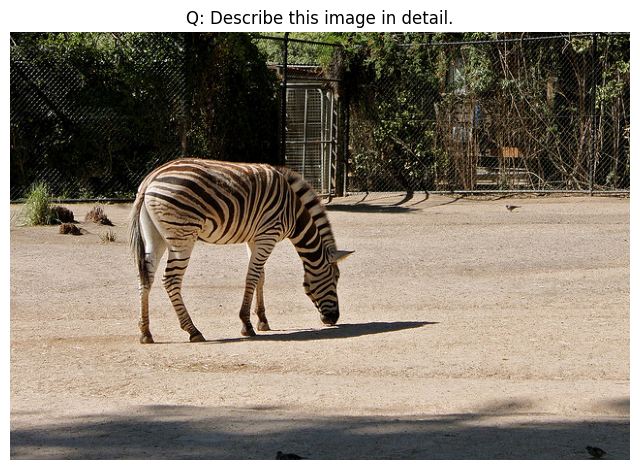

Q: Describe this image in detail.
A: The image depicts a zebra walking along a dirt path, with its head up against the wall. The zebra appears to be standing in a fenced area, close to a fence. The fence is a significant part of the scene, allowing the zebra to be seen by the person walking through the enclosure. 

In the background, there are two cars visible, which are likely a part of the enclosure where the zebra is walking. A small tree can also be seen, adding a


'The image depicts a zebra walking along a dirt path, with its head up against the wall. The zebra appears to be standing in a fenced area, close to a fence. The fence is a significant part of the scene, allowing the zebra to be seen by the person walking through the enclosure. \n\nIn the background, there are two cars visible, which are likely a part of the enclosure where the zebra is walking. A small tree can also be seen, adding a'

In [7]:
# Pick an image
test_image = sample_images[0]

# Ask to describe it
ask(test_image, "Describe this image in detail.", temperature=0.7)

## Test: Object Questions

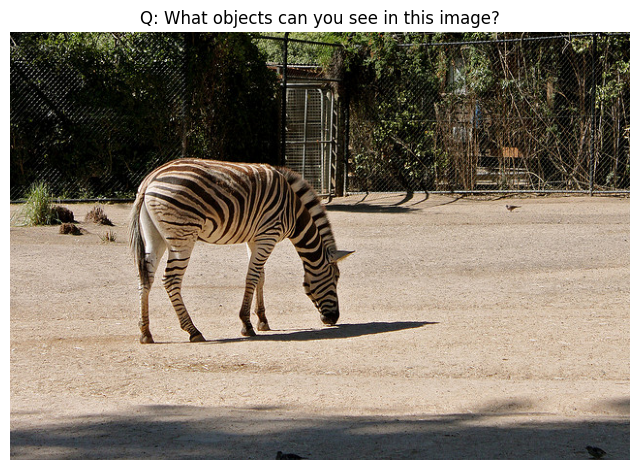

Q: What objects can you see in this image?
A: In the image, a zebra is standing in a dirt field, and a tree is located next to it. There are two trees in the background, one near the left edge of the image and the other slightly further back. The trees are also in the background, creating a picturesque scene of a natural environment.


'In the image, a zebra is standing in a dirt field, and a tree is located next to it. There are two trees in the background, one near the left edge of the image and the other slightly further back. The trees are also in the background, creating a picturesque scene of a natural environment.'

In [8]:
ask(test_image, "What objects can you see in this image?", temperature=0.5)

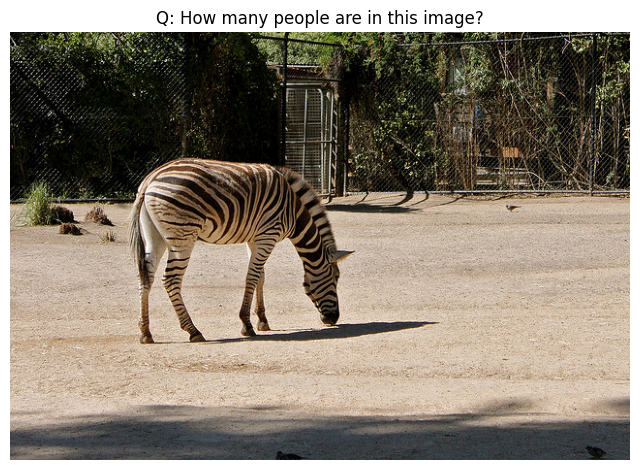

Q: How many people are in this image?
A: There are two people in the image. They are a zebra and a zebra. They are standing next to each other on the dirt road, which is a typical habitat for zebras and zebras.


'There are two people in the image. They are a zebra and a zebra. They are standing next to each other on the dirt road, which is a typical habitat for zebras and zebras.'

In [9]:
ask(test_image, "How many people are in this image?", temperature=0.3)

## Test: Different Images

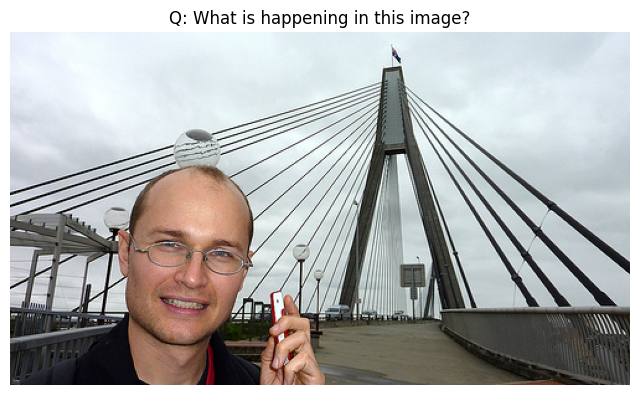

Q: What is happening in this image?
A: The image shows a man sitting in a building, surrounded by a large metal bridge. He appears to be looking up at the camera, possibly looking into the camera. The bridge is surrounded by a city, indicating that it is located in a city setting.

In addition to the man, there are several people in the scene, possibly attending to the man or observing the scene. They can be seen sitting or standing near the bridge, possibly in a public area or at a shopping center.




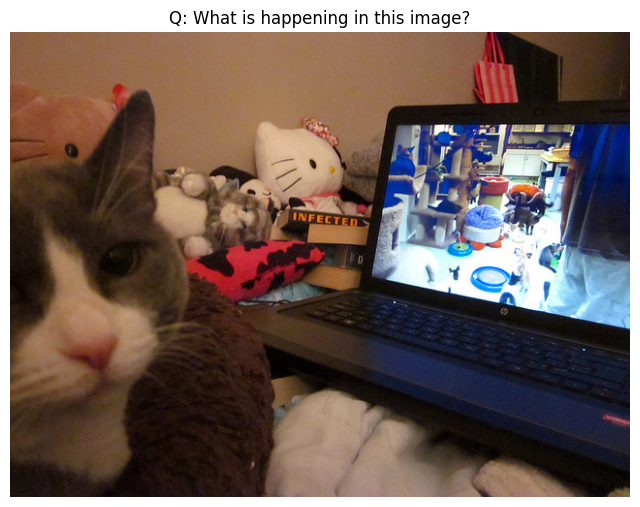

Q: What is happening in this image?
A: In the image, a cat is sitting on a bed, with a laptop computer sitting on top of it. The laptop is placed on the bed, and a laptop can be seen resting on the bed, ready for use. There are two books on the bed, one located close to the laptop and the other located further away. 

A cat is also visible in the scene, sitting on the bed with the laptop on it. The cat appears to be comfortable and content, as it is comfortably




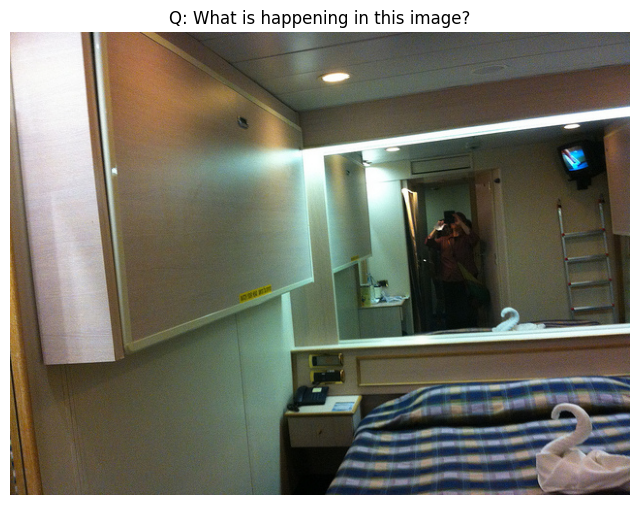

Q: What is happening in this image?
A: The image shows a person lying in bed in a room, in a small room. The bed is covered with a blanket, and the person is lying down in the center of the room. The bed is surrounded by a window, adding to the natural ambiance of the space.

In the room, there are multiple books scattered around, suggesting a gathering or an event. The room also features a few books placed on the floor, suggesting it might be a space for reading or an event.



In [10]:
# Try a few different images
for img_path in sample_images[1:4]:
    print("\n" + "="*60)
    ask(img_path, "What is happening in this image?", temperature=0.7)
    print()

## Test: Greedy Decoding

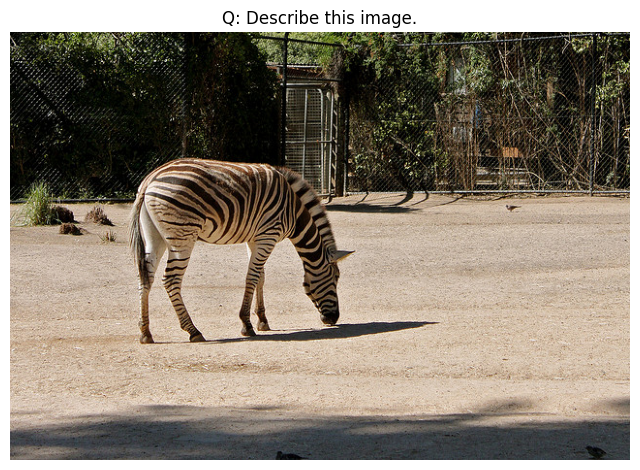

Q: Describe this image.
A: The image features a zebra standing in a dirt field next to a wooden fence. The zebra is positioned in the middle of the scene, with its head resting on the ground. The fence is located near the zebra, and there are several other people in the background, possibly observing or interacting with the zebra.

In the background, there are a few trees, adding to the natural setting of the scene. A few cars are parked further away from the zebra, and


'The image features a zebra standing in a dirt field next to a wooden fence. The zebra is positioned in the middle of the scene, with its head resting on the ground. The fence is located near the zebra, and there are several other people in the background, possibly observing or interacting with the zebra.\n\nIn the background, there are a few trees, adding to the natural setting of the scene. A few cars are parked further away from the zebra, and'

In [11]:
# Greedy decoding (temperature=0) for more deterministic output
ask(sample_images[0], "Describe this image.", temperature=0)

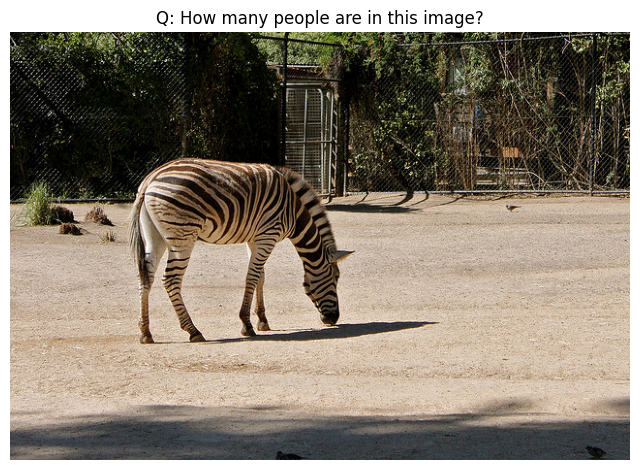

Q: How many people are in this image?
A: There are two people in the image. They are standing next to a fence, and they are standing next to a fence. The fence is located in the background.


'There are two people in the image. They are standing next to a fence, and they are standing next to a fence. The fence is located in the background.'

In [14]:
ask_precise(sample_images[0], "How many people are in this image?")

## Custom Image

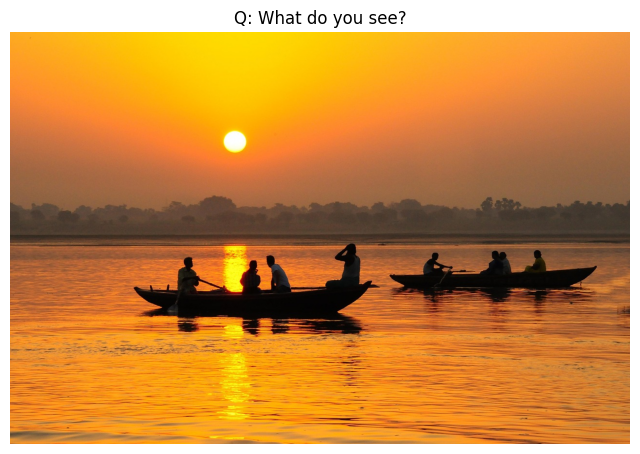

Q: What do you see?
A: The image features a group of people sitting on a small boat on a lake, enjoying a day of water activities. There are at least four people in the scene, with three of them sitting on the boat and others sitting around it. The group appears to be enjoying a leisurely time by the water and the water.

In addition to the people and the boat, there are two umbrellas visible in the scene, one closer to the center of the image and another further away. A book


'The image features a group of people sitting on a small boat on a lake, enjoying a day of water activities. There are at least four people in the scene, with three of them sitting on the boat and others sitting around it. The group appears to be enjoying a leisurely time by the water and the water.\n\nIn addition to the people and the boat, there are two umbrellas visible in the scene, one closer to the center of the image and another further away. A book'

In [12]:
# You can test with any image:
ask('/home/smedar/code_files/llama4-from-scratch/vision_language_alignment/notebooks/sample_image.png', 'What do you see?')

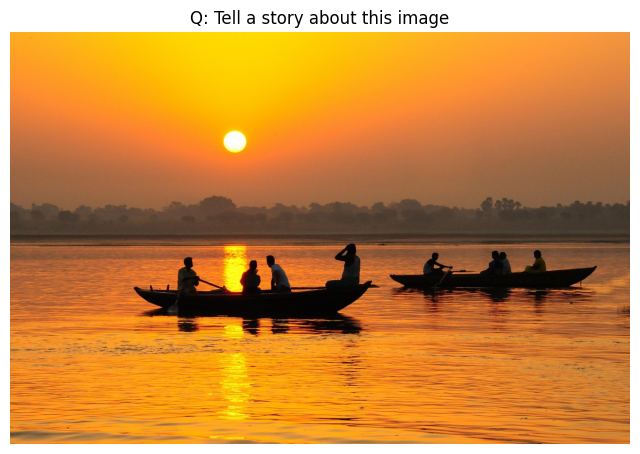

Q: Tell a story about this image
A: A boat in the water is moving into a calm lake, filled with people on horseback. The scene captures a moment of leisure and relaxation as people are gathered around the boat, enjoying the beautiful scenery and the picturesque surroundings.

As the boat is actively floating on the water, several people can be seen resting and reading the book. There are numerous people in the scene, some even from the boat, preparing to set up a racing game or enjoyment of the day. This scene captures a sense of camaraderie and enjoyment of outdoor activities as people engage in diverse activities.


'A boat in the water is moving into a calm lake, filled with people on horseback. The scene captures a moment of leisure and relaxation as people are gathered around the boat, enjoying the beautiful scenery and the picturesque surroundings.\n\nAs the boat is actively floating on the water, several people can be seen resting and reading the book. There are numerous people in the scene, some even from the boat, preparing to set up a racing game or enjoyment of the day. This scene captures a sense of camaraderie and enjoyment of outdoor activities as people engage in diverse activities.'

In [16]:
ask_creative('/home/smedar/code_files/llama4-from-scratch/vision_language_alignment/notebooks/sample_image.png', 'Tell a story about this image')

## Interactive Mode

In [13]:
def interactive_qa(image_path):
    """Interactive Q&A session with an image."""
    image = load_image(image_path)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    print("Ask questions about this image (type 'quit' to exit):")
    print()
    
    while True:
        question = input("Q: ").strip()
        if question.lower() in ['quit', 'exit', 'q']:
            break
        if not question:
            continue
            
        response = generate(image, question, temperature=0.7)
        print(f"A: {response}\n")

# Uncomment to run interactive mode:
# interactive_qa(sample_images[0])